In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import h5py
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import FD as FD_file
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)
home_path = '/home/robynm/simulations/Geometrical/'
sciama_path = '/mnt/lustre/munozr/runs/Geometrical/'
path = sciama_path
simname = 'TestMetric'

In [3]:
allNs = list(np.arange(8, 150, 4))
meanerror_4R = []
meanerror_B2 = []
meanerror_BT = []
meanerror_E2 = []
meanerror_ET = []
for N in allNs:
    L = 20
    t = 1.5
    dx = L/N
    xyz = np.arange(-L/2, L/2, dx)[:N]
    x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
    Box_zero = np.zeros([N, N, N])
    Box_ones = np.ones([N, N, N])

    k = 2*np.pi/L
    A = 2.3+0.2*np.sin(k*z)
    dzA = k*0.2*np.cos(k*z)
    dzdzA = -k*k*0.2*np.sin(k*z)

    Kdown = (-1/2)*np.array([[A, Box_zero, Box_zero],
                                 [Box_zero, A, Box_zero],
                                 [Box_zero, Box_zero, A]])
    RRead.BASH('mkdir '+path+simname+'_N'+str(N))
    RRead.BASH('mkdir '+path+simname+'_N'+str(N)+'/all_iterations')   
    dtfac = 0.05
    dt = dx*dtfac
    t_array = np.arange(1.5-4*dt, 1.5+dt, dt)
    for it, t in enumerate(np.arange(1.5-4*dt, 1.5+dt, dt)):
        gdown = np.array([[t*A, Box_ones, Box_ones],
                          [Box_ones, t*A, Box_zero],
                          [Box_ones, Box_zero, t*A]])
        fname = path+simname+'_N'+str(N)+'/all_iterations/'+simname+'_it_{:06d}.hdf5'.format(it)
        with h5py.File(fname, 'w') as fnew:
            fnew['gxx it={}'.format(it)] = gdown[0,0]
            fnew['gxy it={}'.format(it)] = gdown[0,1]
            fnew['gxz it={}'.format(it)] = gdown[0,2]
            fnew['gyy it={}'.format(it)] = gdown[1,1]
            fnew['gyz it={}'.format(it)] = gdown[1,2]
            fnew['gzz it={}'.format(it)] = gdown[2,2]
            fnew['kxx it={}'.format(it)] = Kdown[0,0]
            fnew['kxy it={}'.format(it)] = Kdown[0,1]
            fnew['kxz it={}'.format(it)] = Kdown[0,2]
            fnew['kyy it={}'.format(it)] = Kdown[1,1]
            fnew['kyz it={}'.format(it)] = Kdown[1,2]
            fnew['kzz it={}'.format(it)] = Kdown[2,2]
            
    RRead.BASH("""printf "%s\n" "simname  = '"""+simname+"""'" "N = """+str(N)+"""" "L = """+str(L)+"""" "dtfac = """+str(dtfac)+"""" "boundary = False" "data_path = '"""+path+simname+'_N'+str(N)+"""/'"> data_analysis_codes/EBWeylparam.py""")
    RRead.BASH("python data_analysis_codes/EBWeyl_test.py")
    
    t = 1.5
    it = np.argmin(abs(t_array-t))
    fname = path+simname+'_N'+str(N)+'/EBWeyl/it={:06d}.hdf5'.format(it)
    f = h5py.File(fname, 'r')
    
    At = A*t
    At2 = (A*t)**2
    g = At*(2 - At**2)
    c1 = 2 - 3*(At**2)
    c2 = 2 + 3*(At**2)
    c3 = - 6 + At**2 + At**4
    p1 = 2*(A**4)*c2 + 8*(At**3)*(dzA**2) + (t**4)*(dzA**4)*(3+At**2)
    p2 = -4*A*(At**2)*g + A*(t**4)*c3*(dzA**2)
    RicciS4th = (A/(2*g*g))*( (-2*A + (t**3)*(dzA**2))*c2 + 4*g*(t**2)*dzdzA )
    meanerror_4R += [np.mean(np.ma.masked_invalid(abs(np.array(f['RicciS4'])/RicciS4th-1)))]
    

    E2th = (p1*(c1**2) + 4*c1*p2*dzdzA - 4*A*(t**3)*c3*g*(dzdzA**2))/(96*(g**4))
    meanerror_E2 += [np.mean(np.ma.masked_invalid(abs(np.array(f['E2'])/E2th-1)))]
    meanerror_ET += [np.mean(np.ma.masked_invalid(abs(np.array(f['Etrace']))))]
    
    B2th = (5*abs(2*A*t - (A**3)*(t**3))*(dzA**2)*(2 + At2)**2 )/(32*At2*(-2 + At2)**5)
    EB2r = np.array(f['B2'])/B2th-1
    EB2r = np.delete(np.delete(EB2r, int(3*N/4), axis=2), int(N/4), axis=2)
    meanerror_B2 += [np.mean(np.ma.masked_invalid(abs(np.array(EB2r))))]
    meanerror_BT += [np.mean(np.ma.masked_invalid(abs(np.array(f['Btrace']))))]
    print('N={}, error={:.2e}, {:.2e}, {:.2e}, {:.2e}, {:.2e}'.format(N, meanerror_4R[-1], meanerror_B2[-1], meanerror_BT[-1], meanerror_E2[-1], meanerror_ET[-1]))
    RRead.BASH('rm -rf '+path+simname+'_N'+str(N))

N=8, error=3.79e-03, 5.83e-01, 5.13e-18, 4.29e-04, 6.29e-17
N=12, error=4.23e-04, 9.62e-02, 8.57e-18, 5.34e-05, 6.36e-17
N=16, error=9.60e-05, 3.04e-02, 5.77e-18, 1.30e-05, 4.63e-17
N=20, error=4.63e-05, 1.17e-02, 8.25e-18, 5.93e-06, 4.12e-17
N=24, error=2.74e-05, 5.08e-03, 1.15e-17, 3.33e-06, 5.55e-17
N=28, error=1.74e-05, 2.52e-03, 1.10e-17, 2.10e-06, 5.20e-17
N=32, error=1.13e-05, 1.39e-03, 1.21e-17, 1.35e-06, 5.91e-17
N=36, error=7.51e-06, 8.26e-04, 1.61e-17, 8.99e-07, 6.36e-17
N=40, error=5.15e-06, 5.23e-04, 1.68e-17, 6.17e-07, 7.04e-17
N=44, error=3.64e-06, 3.47e-04, 1.77e-17, 4.35e-07, 4.93e-17
N=48, error=2.63e-06, 2.41e-04, 1.51e-17, 3.15e-07, 6.54e-17
N=52, error=1.95e-06, 1.73e-04, 1.40e-17, 2.33e-07, 6.19e-17
N=56, error=1.47e-06, 1.28e-04, 1.55e-17, 1.76e-07, 5.33e-17
N=60, error=1.13e-06, 9.63e-05, 2.26e-17, 1.35e-07, 5.47e-17
N=64, error=8.79e-07, 7.39e-05, 2.10e-17, 1.05e-07, 4.29e-17
N=68, error=6.95e-07, 5.77e-05, 2.47e-17, 8.33e-08, 6.12e-17
N=72, error=5.56e-07, 4.5

<IPython.core.display.Javascript object>


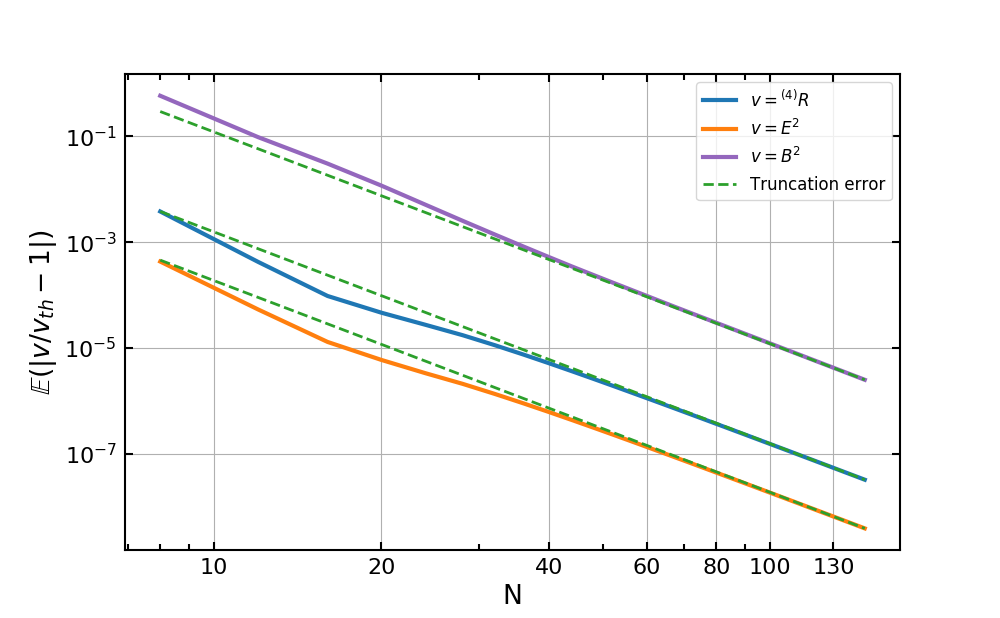

In [6]:
idec = -1


phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))

plt.loglog(allNs, meanerror_4R, 'C0', label=r'$v={}^{(4)}R$')
yplot_4th_order_decrease = [meanerror_4R[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=2)

plt.loglog(allNs, meanerror_E2, 'C1', label=r'$v=E^2$')
yplot_4th_order_decrease = [meanerror_E2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=2)

plt.loglog(allNs, meanerror_B2, 'C4', label=r'$v=B^2$')
yplot_4th_order_decrease = [meanerror_B2[idec]*((allNs[idec]/N)**4) for N in allNs]
plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=2, label='Truncation error') #4th order increase



plt.legend(loc=1, prop={'size': 12})
plt.grid()
plt.xlabel('N')
plt.xticks([10,20,40,60,80,100,130], ['10','20','40','60','80','100','130'])
plt.xlim()
plt.ylabel(r'$\mathbb{E}\left(|v/v_{th}-1|\right)$')
#plt.ylim(1e-11, 1e-7)
plt.savefig('Plots/TestMetric_Geometric_withoutbumps.pdf')

In [7]:
import pandas as pd
data = np.array([allNs, meanerror_4R, meanerror_B2, meanerror_BT, meanerror_E2, meanerror_ET]).T
columns = ['N', '4R', 'B2', 'BT', 'E2', 'ET']
pd.DataFrame(data, columns=columns).to_csv('ErrorData/TestMetric_Geometric_withoutbumps.csv')